In [41]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

from matplotlib import rcParams

rcParams['figure.figsize'] = (10,6)
rcParams['figure.dpi'] = 150
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

## Section 3

###Notes from last time

###Topics for this section
- Review linear regression
- Methods for regression model diagnosis
- Clustering
- k-s test

# `statsmodels`

[statsmodels](http://statsmodels.sourceforge.net) is python module specifically for estimating statistical models (less machine learning compared to `sklearn`). It can estimate many types of statistical models, but today we will focus on linear regression.

### Quick reminder about linear regression and least squares

[Linear regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explantory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship bewteen each predictor $X$ is linearly related to the dependent variable $Y$.  

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

On Tuesday in lecture, we learned how to write this model using matrix multiplication 

$$ Y = \beta X + \epsilon$$ 

where $Y$ has dimensions $n \times 1$, $X$ has dimensions $n \times p$ and $\epsilon$ has dimensions $n \times 1$.  On Tuesday, we also derived the [least squares](http://en.wikipedia.org/wiki/Least_squares) estimates of the coefficients of a linear model. These estimates minimize the difference between the following: 

$$ S = \sum_{i=1}^n r_i = \sum_{i=1}^n (y_i - (\beta_0 + \beta_1 x_i))^2 $$

where $n$ is the number of observations.  

> The least squares estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ minimize the sum of the squared residuals $r_i = y_i - (\beta_0 + \beta_1 x_i)$ in the model (i.e. makes the difference bewteen the observed $y_i$ and linear model $\beta_0 + \beta_1 x_i$ as small as possible). 

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
# What's the target? What are the features?
boston.keys()

dict_keys(['DESCR', 'data', 'feature_names', 'target'])

In [4]:
boston.data.shape

(506, 13)

In [5]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [6]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [7]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [8]:
bos.columns = boston.feature_names[:]
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [9]:
bos['PRICE'] = boston.target

## Data Exploration

In [10]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Histograms

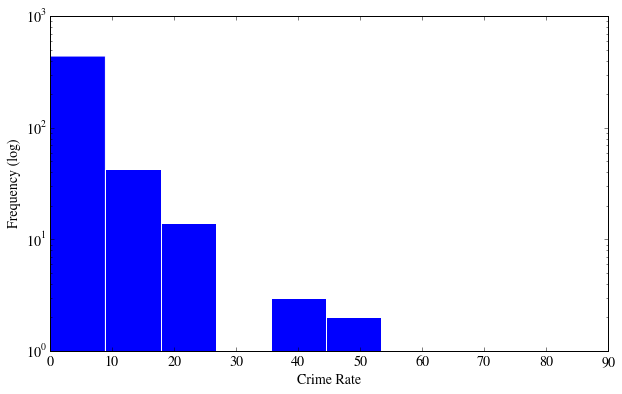

In [11]:
plt.hist(bos.CRIM)
plt.xlabel('Crime Rate')
plt.ylabel('Frequency (log)')
plt.yscale('log')

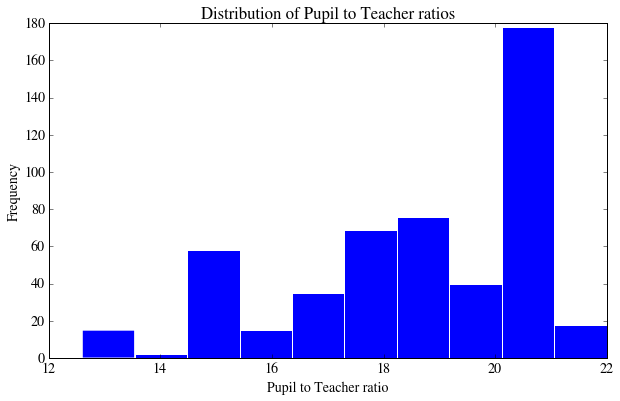

In [13]:
plt.hist(bos.PTRATIO)
plt.xlabel('Pupil to Teacher ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Pupil to Teacher ratios')
plt.show()

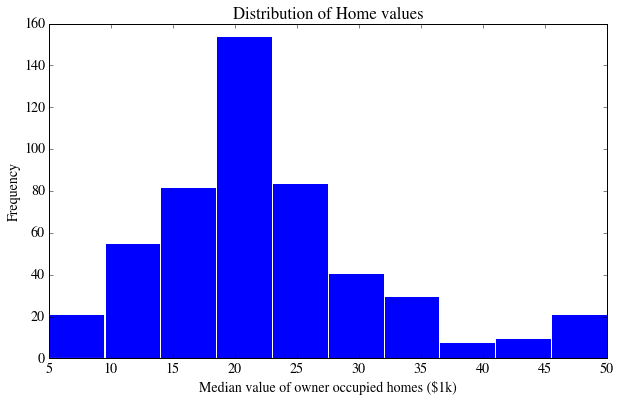

In [14]:
plt.hist(bos.PRICE)
plt.xlabel('Median value of owner occupied homes ($1k)')
plt.ylabel('Frequency')
plt.title('Distribution of Home values')
plt.show()

### Scatterplots

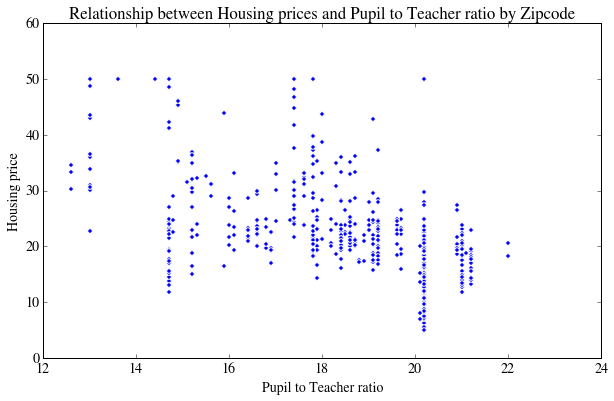

In [14]:
plt.scatter(bos.PTRATIO, bos.PRICE)
plt.xlabel('Pupil to Teacher ratio')
plt.ylabel('Housing price')
plt.title('Relationship between Housing prices and Pupil to Teacher ratio by Zipcode')
plt.show()

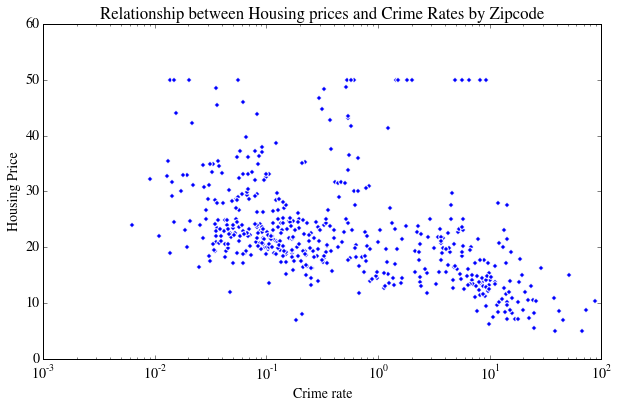

In [15]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel('Crime rate')
plt.ylabel('Housing Price')
plt.title('Relationship between Housing prices and Crime Rates by Zipcode')
plt.xscale('log')
plt.show()

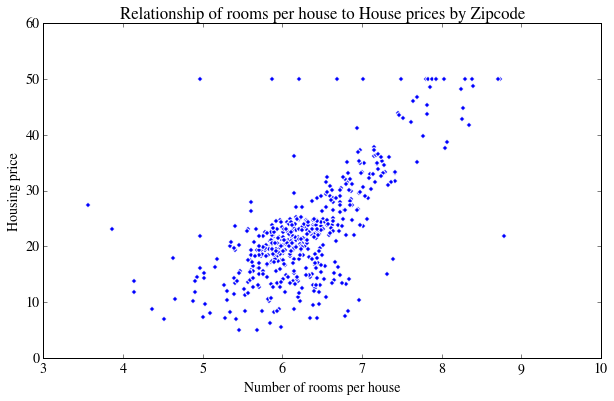

In [16]:
plt.scatter(bos.RM, bos.PRICE)
plt.xlabel('Number of rooms per house')
plt.ylabel('Housing price')
plt.title('Relationship of rooms per house to House prices by Zipcode')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d862080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1296ab518>]], dtype=object)

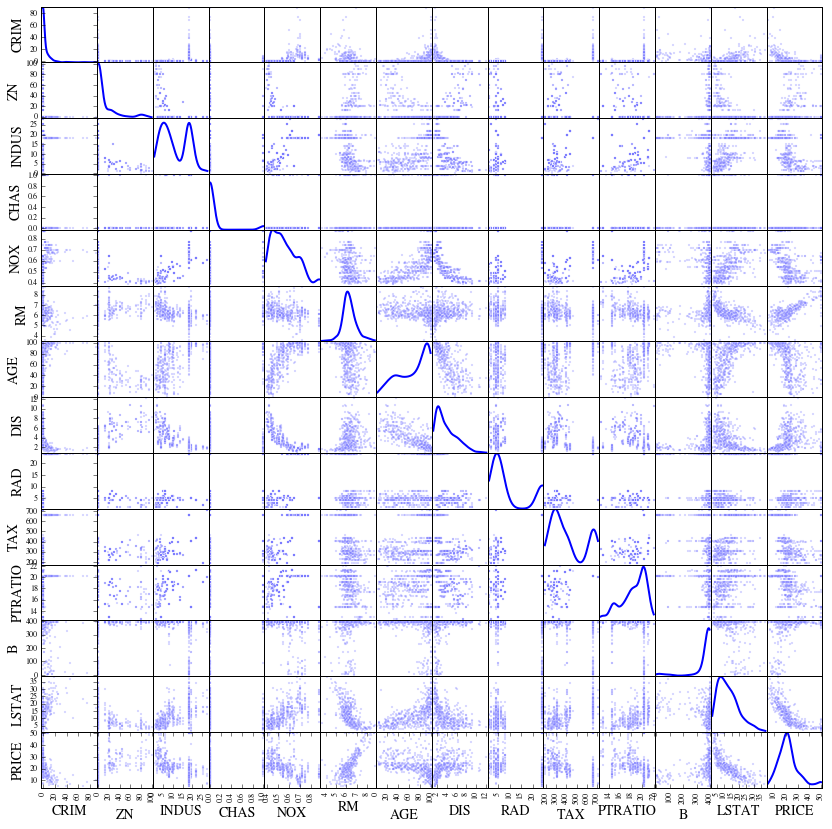

In [18]:
pd.scatter_matrix(bos, alpha=0.2, figsize=(14,14), diagonal='kde')

In [19]:
features = boston.feature_names
X = bos[features]
Y = bos['PRICE']
# sm.OLS?
model = sm.OLS(Y, X)

In [20]:
results = model.fit()

In [21]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     891.1
Date:                Fri, 18 Sep 2015   Prob (F-statistic):               0.00
Time:                        19:57:22   Log-Likelihood:                -1523.8
No. Observations:                 506   AIC:                             3074.
Df Residuals:                     493   BIC:                             3129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
CRIM          -0.0916      0.034     -2.675      0.0

How do we use the model to predict housing prices? What is the equation? 

$$ \hat{y} = \hat{\beta}_0 + \hat{\beta}_1 * CRIM + \hat{\beta}_2 * ZN + \hat{\beta}_3 * INDUS  +  \hat{\beta}_4 * CHAS + ... $$ 

or you can use `results.predict`  

In [22]:
X = bos['RM']
Y = bos['PRICE']
model = sm.OLS(Y,X)

In [23]:
results = model.fit()

In [24]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     4615.
Date:                Fri, 18 Sep 2015   Prob (F-statistic):          3.74e-256
Time:                        19:57:28   Log-Likelihood:                -1747.1
No. Observations:                 506   AIC:                             3496.
Df Residuals:                     505   BIC:                             3500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
RM             3.6534      0.054     67.930      0.0

This model doesn't include a constant coefficient.  But we can add one in using the add_constant method. 

In [25]:
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Fri, 18 Sep 2015   Prob (F-statistic):           2.49e-74
Time:                        19:57:32   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -34.6706      2.650    -13.084      0.0

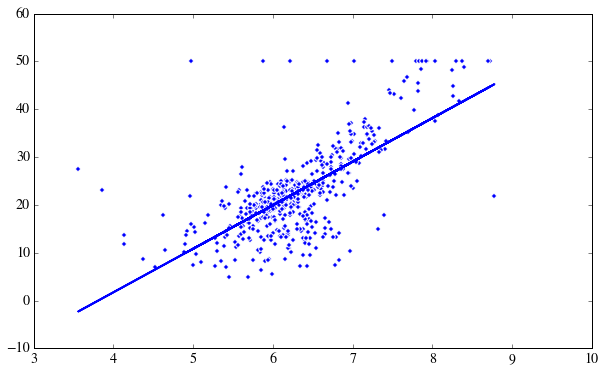

In [26]:
plt.scatter(bos.RM, bos.PRICE)

plt.plot(bos.RM, results.fittedvalues)
plt.show()

### Residuals, residual sum of squares, mean squared error

Recall, we can directly calculate the residuals as 

$$r_i = y_i - (\hat{\beta}_0 + \hat{\beta}_1 x_i)$$

To calculate the residual sum of squares, 

$$ S = \sum_{i=1}^n r_i = \sum_{i=1}^n (y_i - (\hat{\beta}_0 + \hat{\beta}_1 x_i))^2 $$

where $n$ is the number of observations.  Alternatively, we can simply ask for the residuals using `resultsW0.predict`

In [27]:
results.predict?

In [28]:
residuals = bos.PRICE - results.predict(X)
residuals.head()

0   -1.175746
1   -2.174021
2    3.971968
3    4.374062
4    5.817848
Name: PRICE, dtype: float64

In [29]:
residuals = results.resid
residuals.head()

0   -1.175746
1   -2.174021
2    3.971968
3    4.374062
4    5.817848
dtype: float64

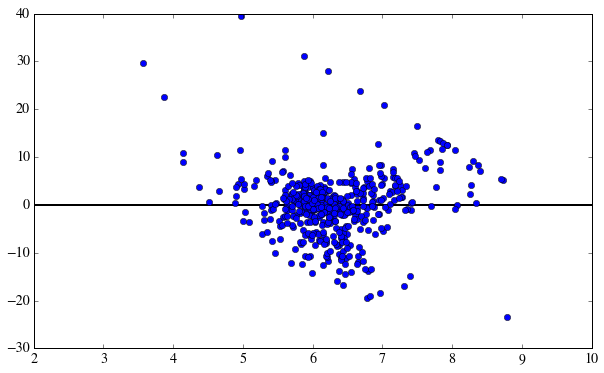

In [30]:
plt.plot(bos.RM, residuals, 'o')
plt.hlines(y = 0, xmin = 2, xmax = 10)
plt.show()

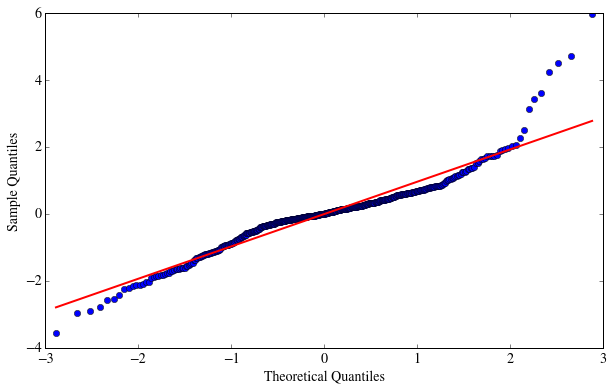

In [31]:
fig = sm.qqplot(residuals, fit=True, line='r')
plt.show()

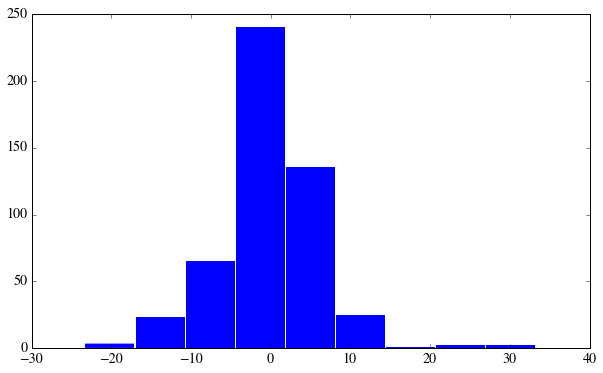

In [32]:
plt.hist(residuals)
plt.show()

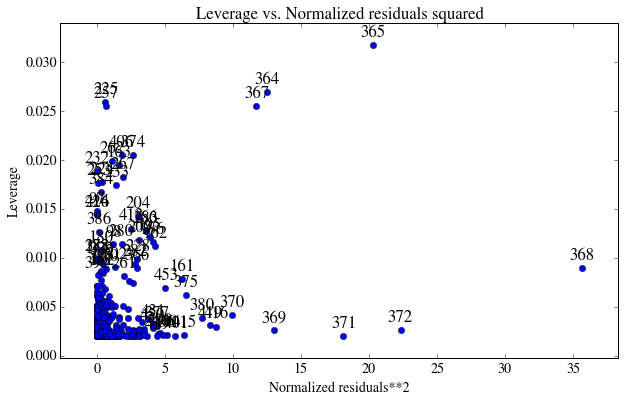

In [33]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig = plot_leverage_resid2(results)
plt.show()

### Revisit regression model for full feature set for Boston Housing data

In [34]:
X = bos[features]
X = sm.add_constant(X)
Y = bos['PRICE']
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Fri, 18 Sep 2015   Prob (F-statistic):          6.95e-135
Time:                        19:59:02   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         36.4911      5.104      7.149      0.0

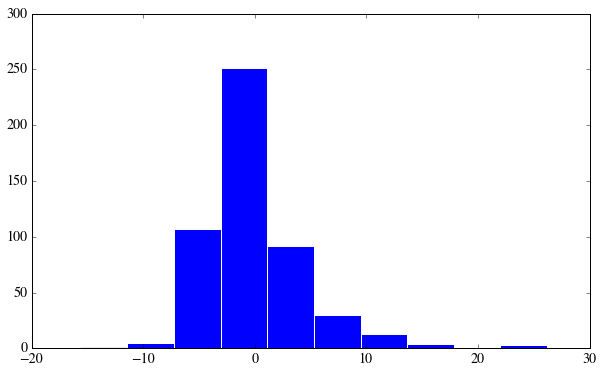

In [35]:
plt.hist(results.resid)
plt.show()

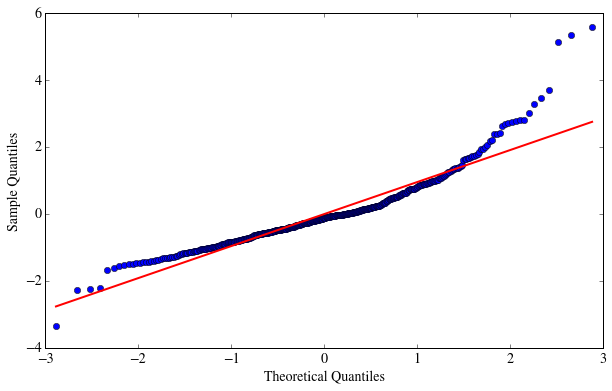

In [36]:
fig = sm.qqplot(results.resid, fit=True, line='r')
plt.show()

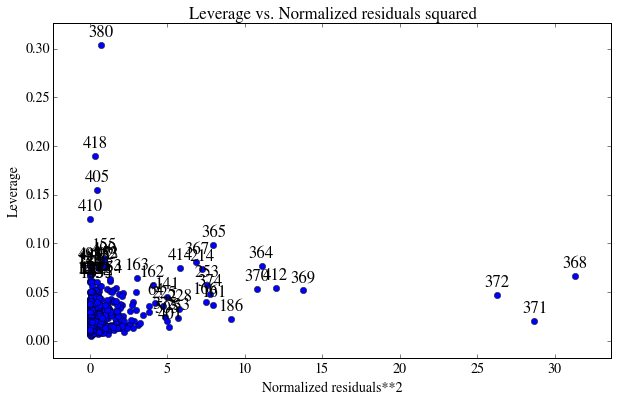

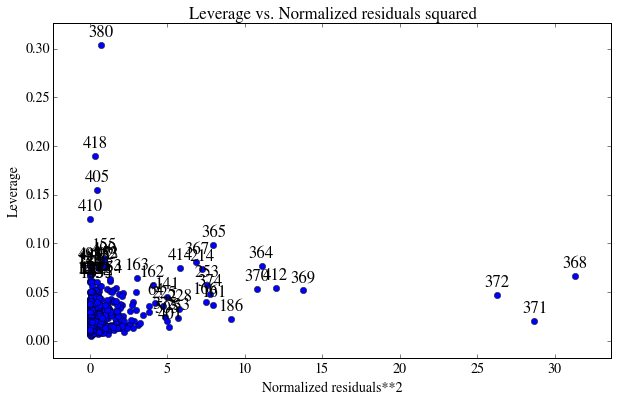

In [37]:
plot_leverage_resid2(results)

In [38]:
from statsmodels.graphics.regressionplots import influence_plot

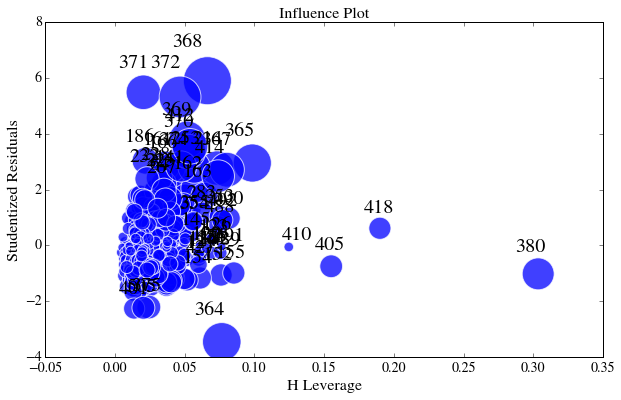

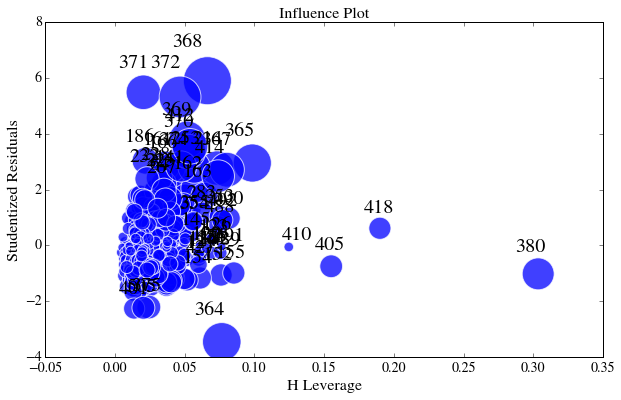

In [39]:
influence_plot(results)

We can inspect the data that are outliers with large leverage to see if they are valid data or if they should be removed. 

In [40]:
bos[415:420]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
415,18.0846,0,18.1,0,0.679,6.434,100.0,1.8347,24,666,20.2,27.25,29.05,7.2
416,10.8342,0,18.1,0,0.679,6.782,90.8,1.8195,24,666,20.2,21.57,25.79,7.5
417,25.9406,0,18.1,0,0.679,5.304,89.1,1.6475,24,666,20.2,127.36,26.64,10.4
418,73.5341,0,18.1,0,0.679,5.957,100.0,1.8026,24,666,20.2,16.45,20.62,8.8
419,11.8123,0,18.1,0,0.718,6.824,76.5,1.7940,24,666,20.2,48.45,22.74,8.4


---------------------

#  $k$-Means Clustering

We'll work with the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library.  

In [65]:
#load the iris data set
iris = sklearn.datasets.load_iris()

X = iris.data  
y = iris.target

print(X.shape, y.shape)

(150, 4) (150,)


In [71]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:
    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================
    :Missing Attribute Values: None
    

This sets the random seed for the random number generator.  This ensures we'll always get the same result everytime we run this notebook even though we're asking for a random number.  

In [66]:
np.random.seed(5)

Setup the initial center points

In [67]:
centers = [[1, 1], [-1, -1], [1, -1]]

Create a few estimators to see the differences between using different numbers of clusters.  The [KMeans](http://scikit-learn.org/stable/modules/clustering.html#k-means) API is well documented and very simple to use.  

In [68]:
estimators = {'k_means_iris_3': KMeans(n_clusters=3),
              'k_means_iris_8': KMeans(n_clusters=8),
              'k_means_iris_bad_init': KMeans(n_clusters=3, n_init=1,
                                              init='random')}

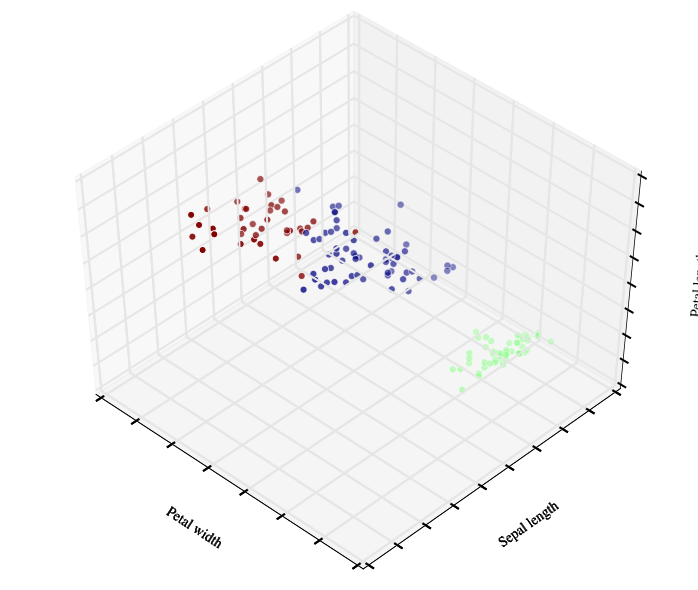

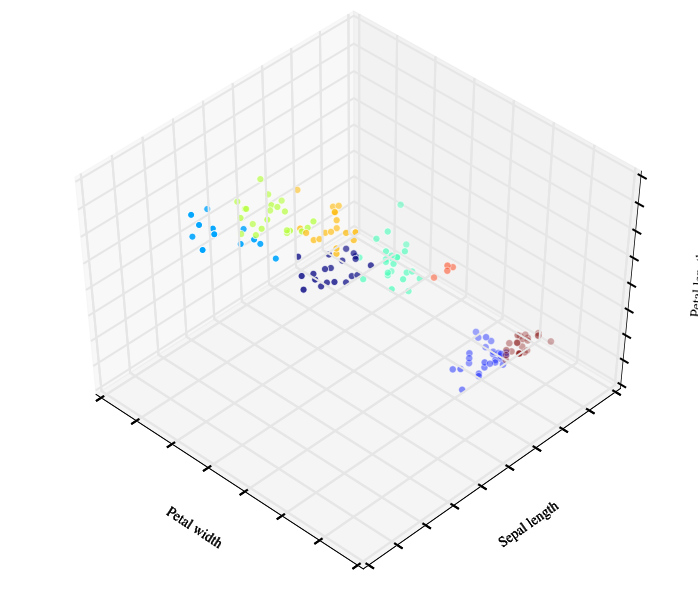

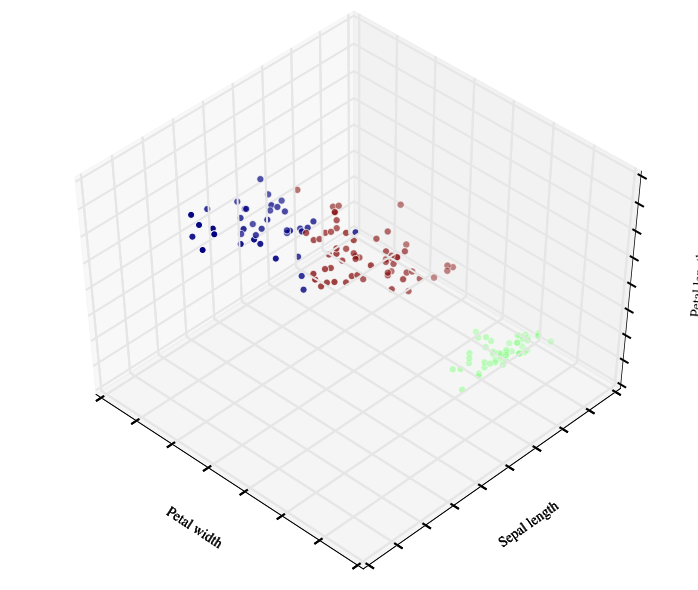

In [69]:
fignum = 1
for name, est in estimators.items():
    fig = plt.figure(fignum, figsize=(10, 8))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(np.float), s=50)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Petal width')
    ax.set_ylabel('Sepal length')
    ax.set_zlabel('Petal length')
    fignum = fignum + 1

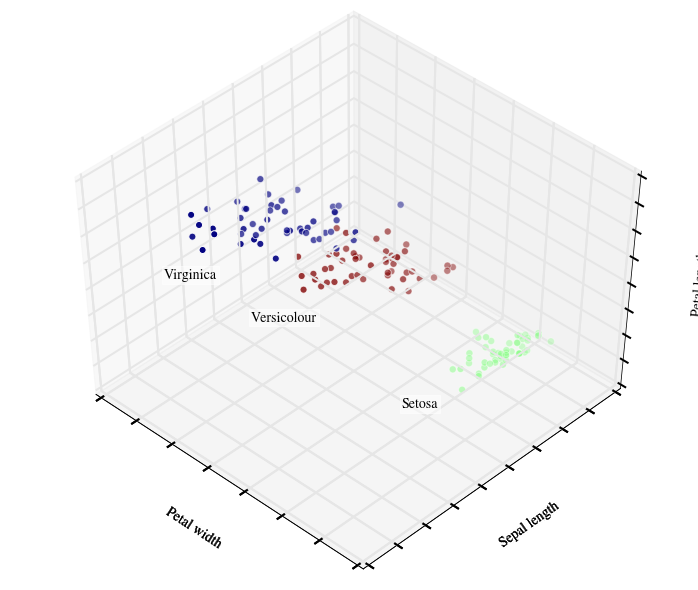

In [70]:
# Plot the ground truth
fig = plt.figure(fignum, figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0),
                    ('Versicolour', 1),
                    ('Virginica', 2)]:
    ax.text3D(X[y == label, 3].mean(),
              X[y == label, 0].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
    
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, s = 50)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')
plt.show()

--------------------